# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


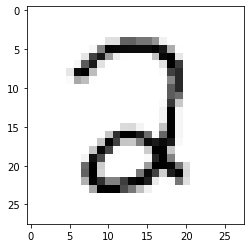

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2081
Training Accuracy: 0.7970, Testing Accuracy: 0.8246



Epoch 10, Loss 0.0704
Training Accuracy: 0.9251, Testing Accuracy: 0.9370



Epoch 20, Loss 0.0487
Training Accuracy: 0.9460, Testing Accuracy: 0.9572



Epoch 30, Loss 0.0405
Training Accuracy: 0.9523, Testing Accuracy: 0.9652



Epoch 40, Loss 0.0359
Training Accuracy: 0.9589, Testing Accuracy: 0.9677



Epoch 50, Loss 0.0328
Training Accuracy: 0.9615, Testing Accuracy: 0.9708



Epoch 60, Loss 0.0306
Training Accuracy: 0.9638, Testing Accuracy: 0.9723



Epoch 70, Loss 0.0289
Training Accuracy: 0.9657, Testing Accuracy: 0.9723



Epoch 80, Loss 0.0274
Training Accuracy: 0.9676, Testing Accuracy: 0.9733



Epoch 90, Loss 0.0262
Training Accuracy: 0.9690, Testing Accuracy: 0.9718



Epoch 100, Loss 0.0251
Training Accuracy: 0.9702, Testing Accuracy: 0.9738



Epoch 110, Loss 0.0242
Training Accuracy: 0.9720, Testing Accuracy: 0.9748



Epoch 120, Loss 0.0234
Training Accuracy: 0.9735, Testing Accuracy: 0.9743



Epoch 130, Loss 0.0226
Training Accuracy: 0.9748, Testing Accuracy: 0.9753



Epoch 140, Loss 0.0219
Training Accuracy: 0.9752, Testing Accuracy: 0.9748



Epoch 150, Loss 0.0213
Training Accuracy: 0.9755, Testing Accuracy: 0.9763



Epoch 160, Loss 0.0207
Training Accuracy: 0.9762, Testing Accuracy: 0.9768



Epoch 170, Loss 0.0201
Training Accuracy: 0.9768, Testing Accuracy: 0.9773



Epoch 180, Loss 0.0196
Training Accuracy: 0.9775, Testing Accuracy: 0.9773



Epoch 190, Loss 0.019
Training Accuracy: 0.9782, Testing Accuracy: 0.9773



Epoch 200, Loss 0.0185
Training Accuracy: 0.9788, Testing Accuracy: 0.9783



Epoch 210, Loss 0.018
Training Accuracy: 0.9793, Testing Accuracy: 0.9788



Epoch 220, Loss 0.0176
Training Accuracy: 0.9801, Testing Accuracy: 0.9783



Epoch 230, Loss 0.0171
Training Accuracy: 0.9804, Testing Accuracy: 0.9788



Epoch 240, Loss 0.0167
Training Accuracy: 0.9811, Testing Accuracy: 0.9788



0.034053237067536817

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.227
Training Accuracy: 0.7432, Testing Accuracy: 0.7319



Epoch 10, Loss 0.1011
Training Accuracy: 0.9130, Testing Accuracy: 0.9173



Epoch 20, Loss 0.0786
Training Accuracy: 0.9284, Testing Accuracy: 0.9400



Epoch 30, Loss 0.0679
Training Accuracy: 0.9365, Testing Accuracy: 0.9461



Epoch 40, Loss 0.0614
Training Accuracy: 0.9417, Testing Accuracy: 0.9501



Epoch 50, Loss 0.0569
Training Accuracy: 0.9454, Testing Accuracy: 0.9536



Epoch 60, Loss 0.0536
Training Accuracy: 0.9473, Testing Accuracy: 0.9551



Epoch 70, Loss 0.0511
Training Accuracy: 0.9487, Testing Accuracy: 0.9567



Epoch 80, Loss 0.0491
Training Accuracy: 0.9503, Testing Accuracy: 0.9582



Epoch 90, Loss 0.0474
Training Accuracy: 0.9519, Testing Accuracy: 0.9582



Epoch 100, Loss 0.046
Training Accuracy: 0.9529, Testing Accuracy: 0.9592



Epoch 110, Loss 0.0448
Training Accuracy: 0.9540, Testing Accuracy: 0.9612



Epoch 120, Loss 0.0438
Training Accuracy: 0.9550, Testing Accuracy: 0.9617



Epoch 130, Loss 0.0428
Training Accuracy: 0.9553, Testing Accuracy: 0.9622



Epoch 140, Loss 0.042
Training Accuracy: 0.9559, Testing Accuracy: 0.9632



Epoch 150, Loss 0.0413
Training Accuracy: 0.9564, Testing Accuracy: 0.9637



Epoch 160, Loss 0.0406
Training Accuracy: 0.9572, Testing Accuracy: 0.9637



Epoch 170, Loss 0.04
Training Accuracy: 0.9577, Testing Accuracy: 0.9637



Epoch 180, Loss 0.0394
Training Accuracy: 0.9579, Testing Accuracy: 0.9642



Epoch 190, Loss 0.0389
Training Accuracy: 0.9584, Testing Accuracy: 0.9647



Epoch 200, Loss 0.0384
Training Accuracy: 0.9589, Testing Accuracy: 0.9647



Epoch 210, Loss 0.038
Training Accuracy: 0.9589, Testing Accuracy: 0.9642



Epoch 220, Loss 0.0376
Training Accuracy: 0.9592, Testing Accuracy: 0.9642



Epoch 230, Loss 0.0372
Training Accuracy: 0.9597, Testing Accuracy: 0.9642



Epoch 240, Loss 0.0369
Training Accuracy: 0.9602, Testing Accuracy: 0.9642



0.021209477075058644

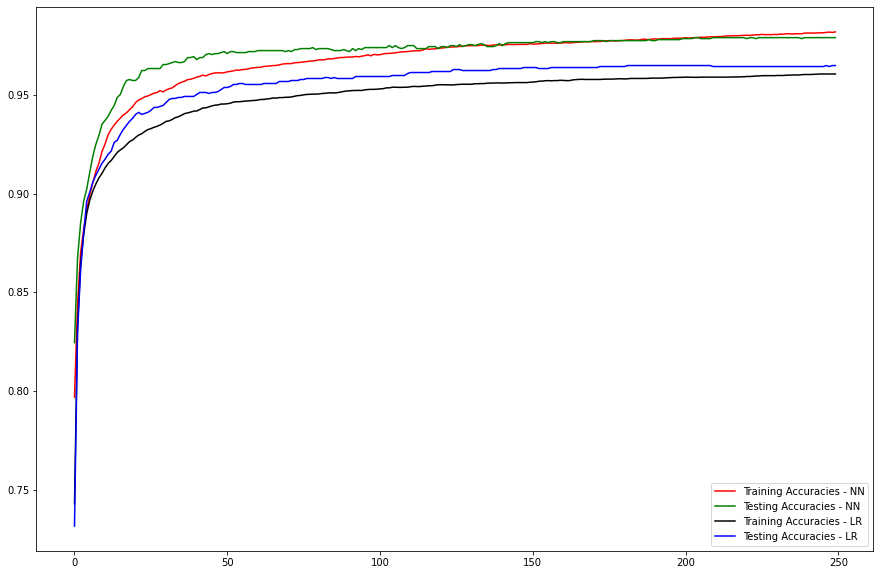

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

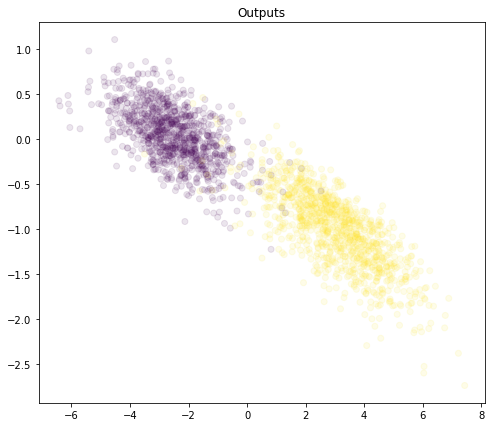

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

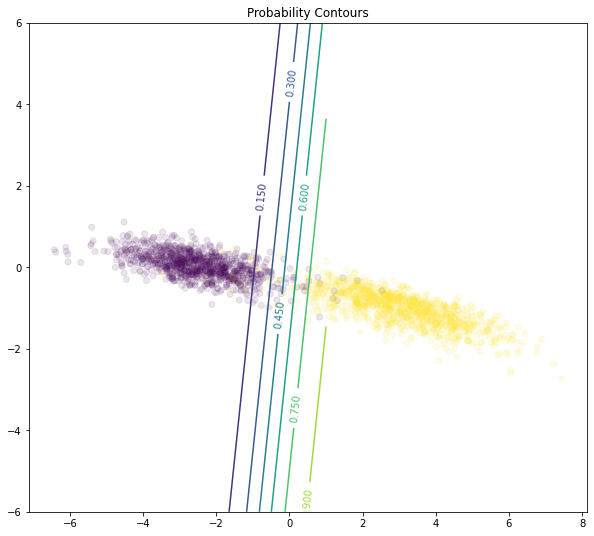

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );